## Clustering
Put simply, the task of clustering is to place observations that seem similar within the same cluster. Clustering is commonly used in two dimensional data where the goal is to create clusters based on coordinates. Here, we will use something similar. We will cluster houses based on their latitude-longitude locations using several different clustering methods.

In [1]:
# Packages we will use throughout this notebook
using Clustering
using VegaLite
using VegaDatasets
using DataFrames
using Statistics
using JSON
using CSV
using Distances

We will start off by getting some data. We will use data of 20,000+ California houses dataset. We will then learn whether housing prices directly correlate with map location.

In [2]:
download("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv","newhouses.csv")
houses = CSV.read("newhouses.csv", DataFrame);

In [3]:
names(houses)

10-element Vector{String}:
 "longitude"
 "latitude"
 "housing_median_age"
 "total_rooms"
 "total_bedrooms"
 "population"
 "households"
 "median_income"
 "median_house_value"
 "ocean_proximity"

In [4]:
function show_map(p, ppi=300)
    io = IOBuffer()
    Base.show(IOContext(io, :ppi => ppi), MIME"image/png"(), p)
    display("image/png", take!(io))
end

show_map (generic function with 2 methods)

We will use the `VegaLite` package here for plotting. This package makes it very easy to plot information on a map. All you need is a JSON file of the map you intend to draw. Here, we will use the California counties JSON file and plot each house on the map and color code it via a heatmap of the price. This is done by this line `color="median_house_value:q"`

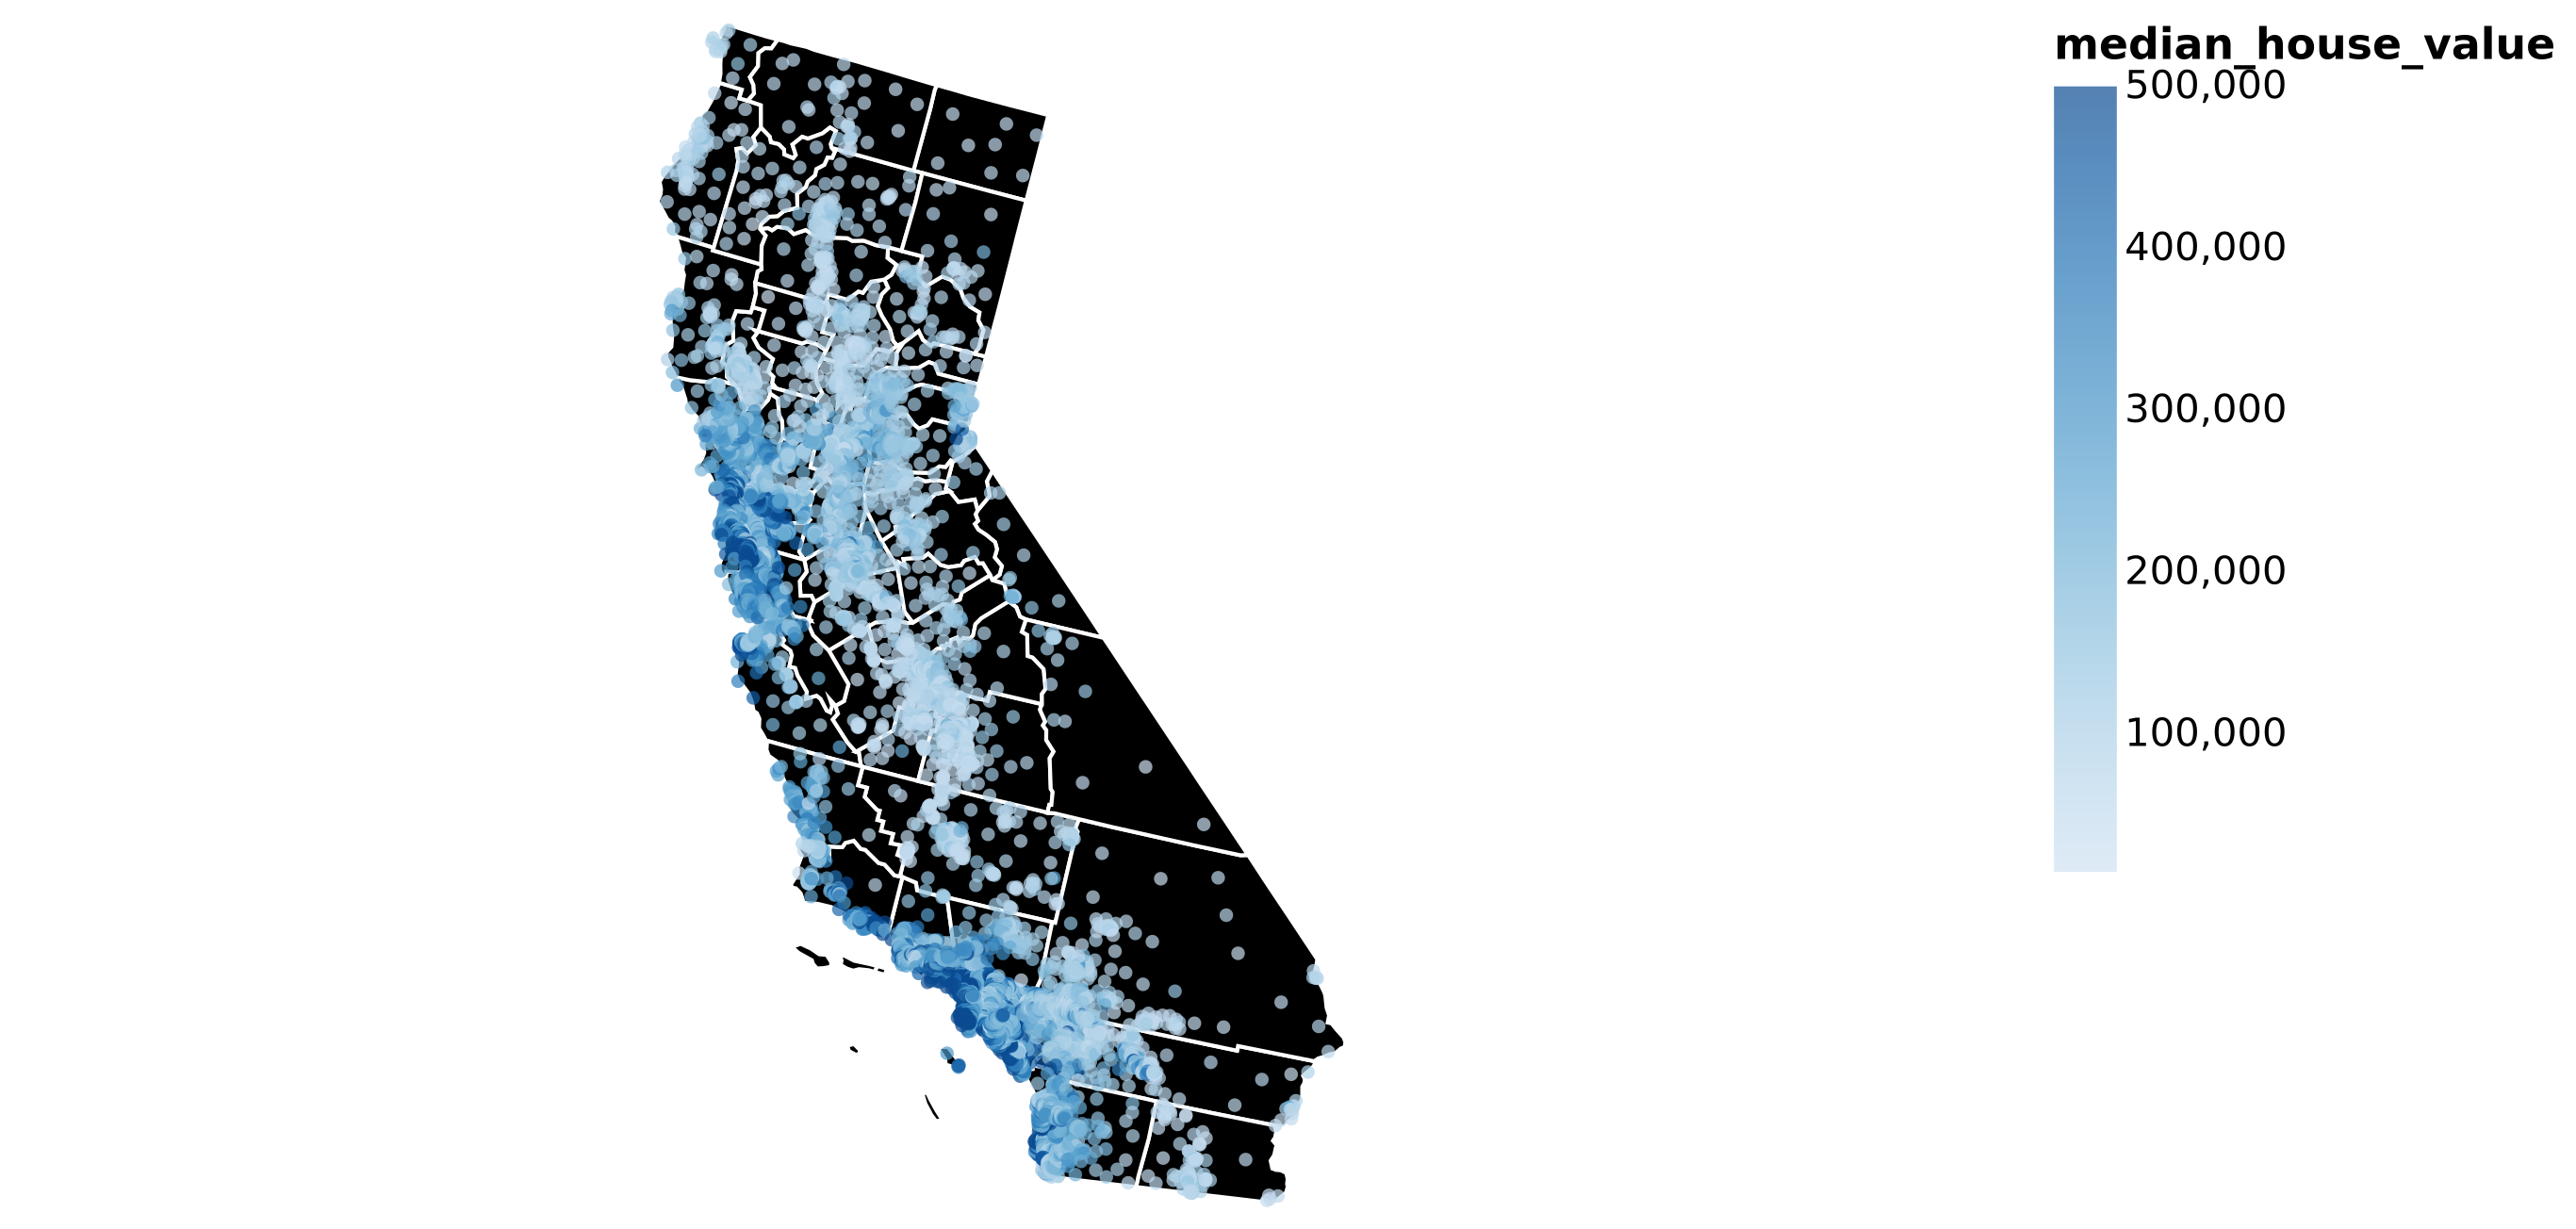

In [5]:
cali_shape = JSON.parsefile("data/california-counties.json")
VV = VegaDatasets.VegaJSONDataset(cali_shape,"data/california-counties.json")

p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="median_house_value:q"
                    
);

p |> show_map

One thing we will try and explore in this notebook is if clustering the houses has any direct relationship with their prices, so we will bucket the houses into intervals of $50000 and re perform the color codes based on each bucket.

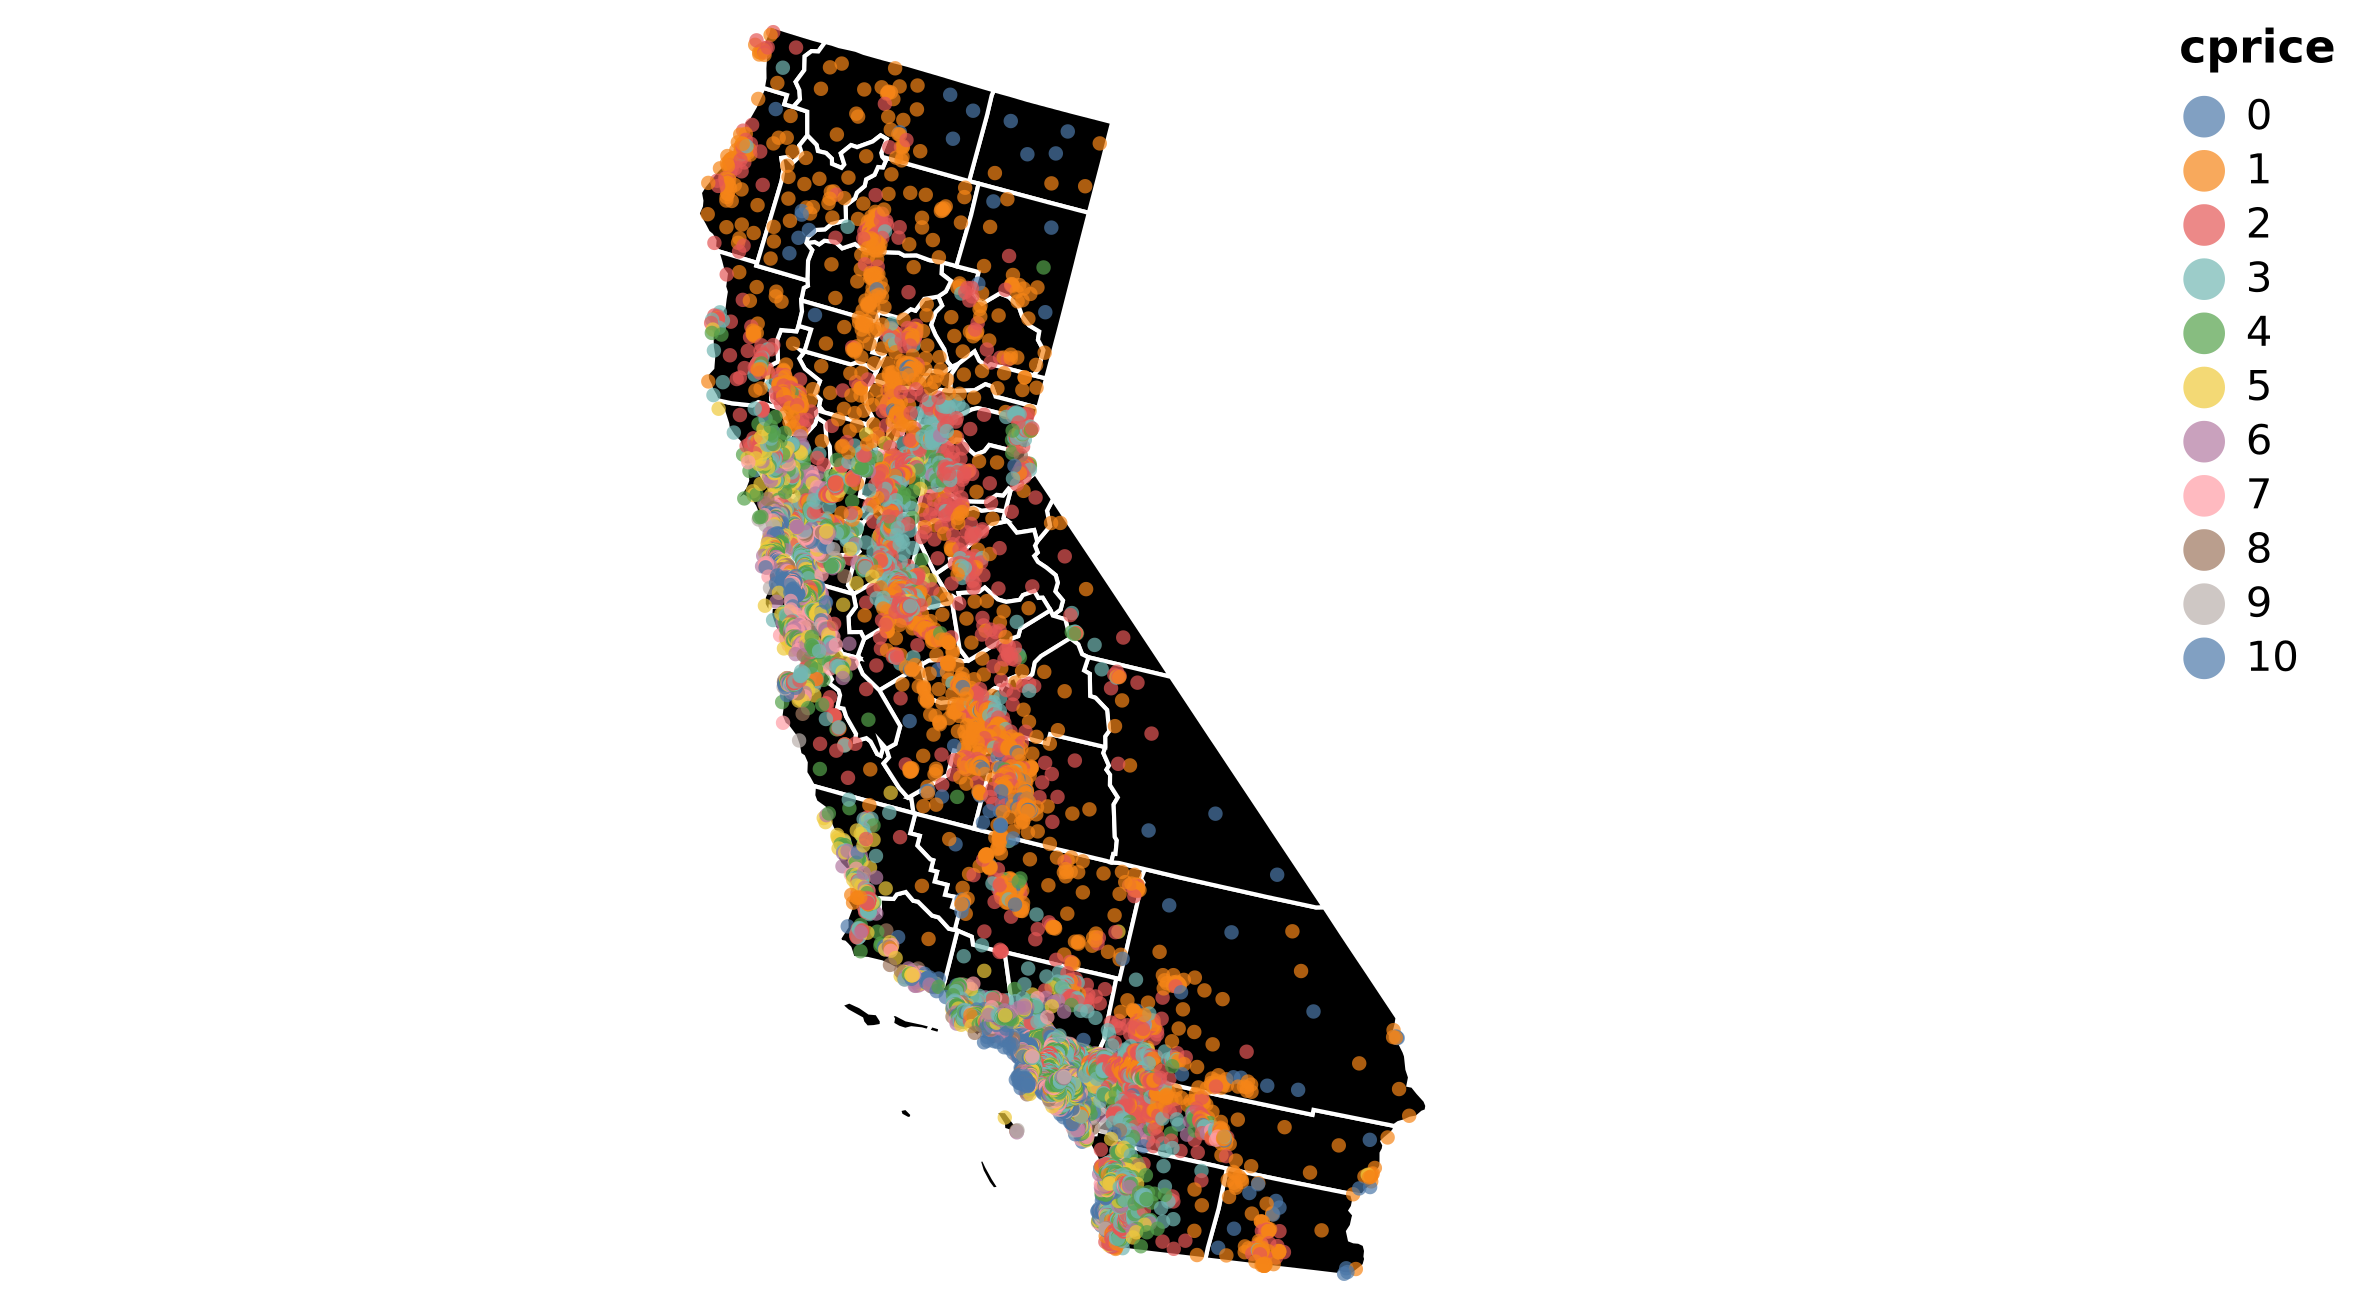

In [6]:
bucketprice = Int.(div.(houses[!,:median_house_value],50000))
insertcols!(houses,3,:cprice=>bucketprice)

p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="cprice:n"
                    
)

p |> show_map

### 🟤K-means clustering

In [7]:
X = houses[!, [:latitude,:longitude]]
C = kmeans(Matrix(X)', 10) 
insertcols!(houses,3,:cluster10=>C.assignments);

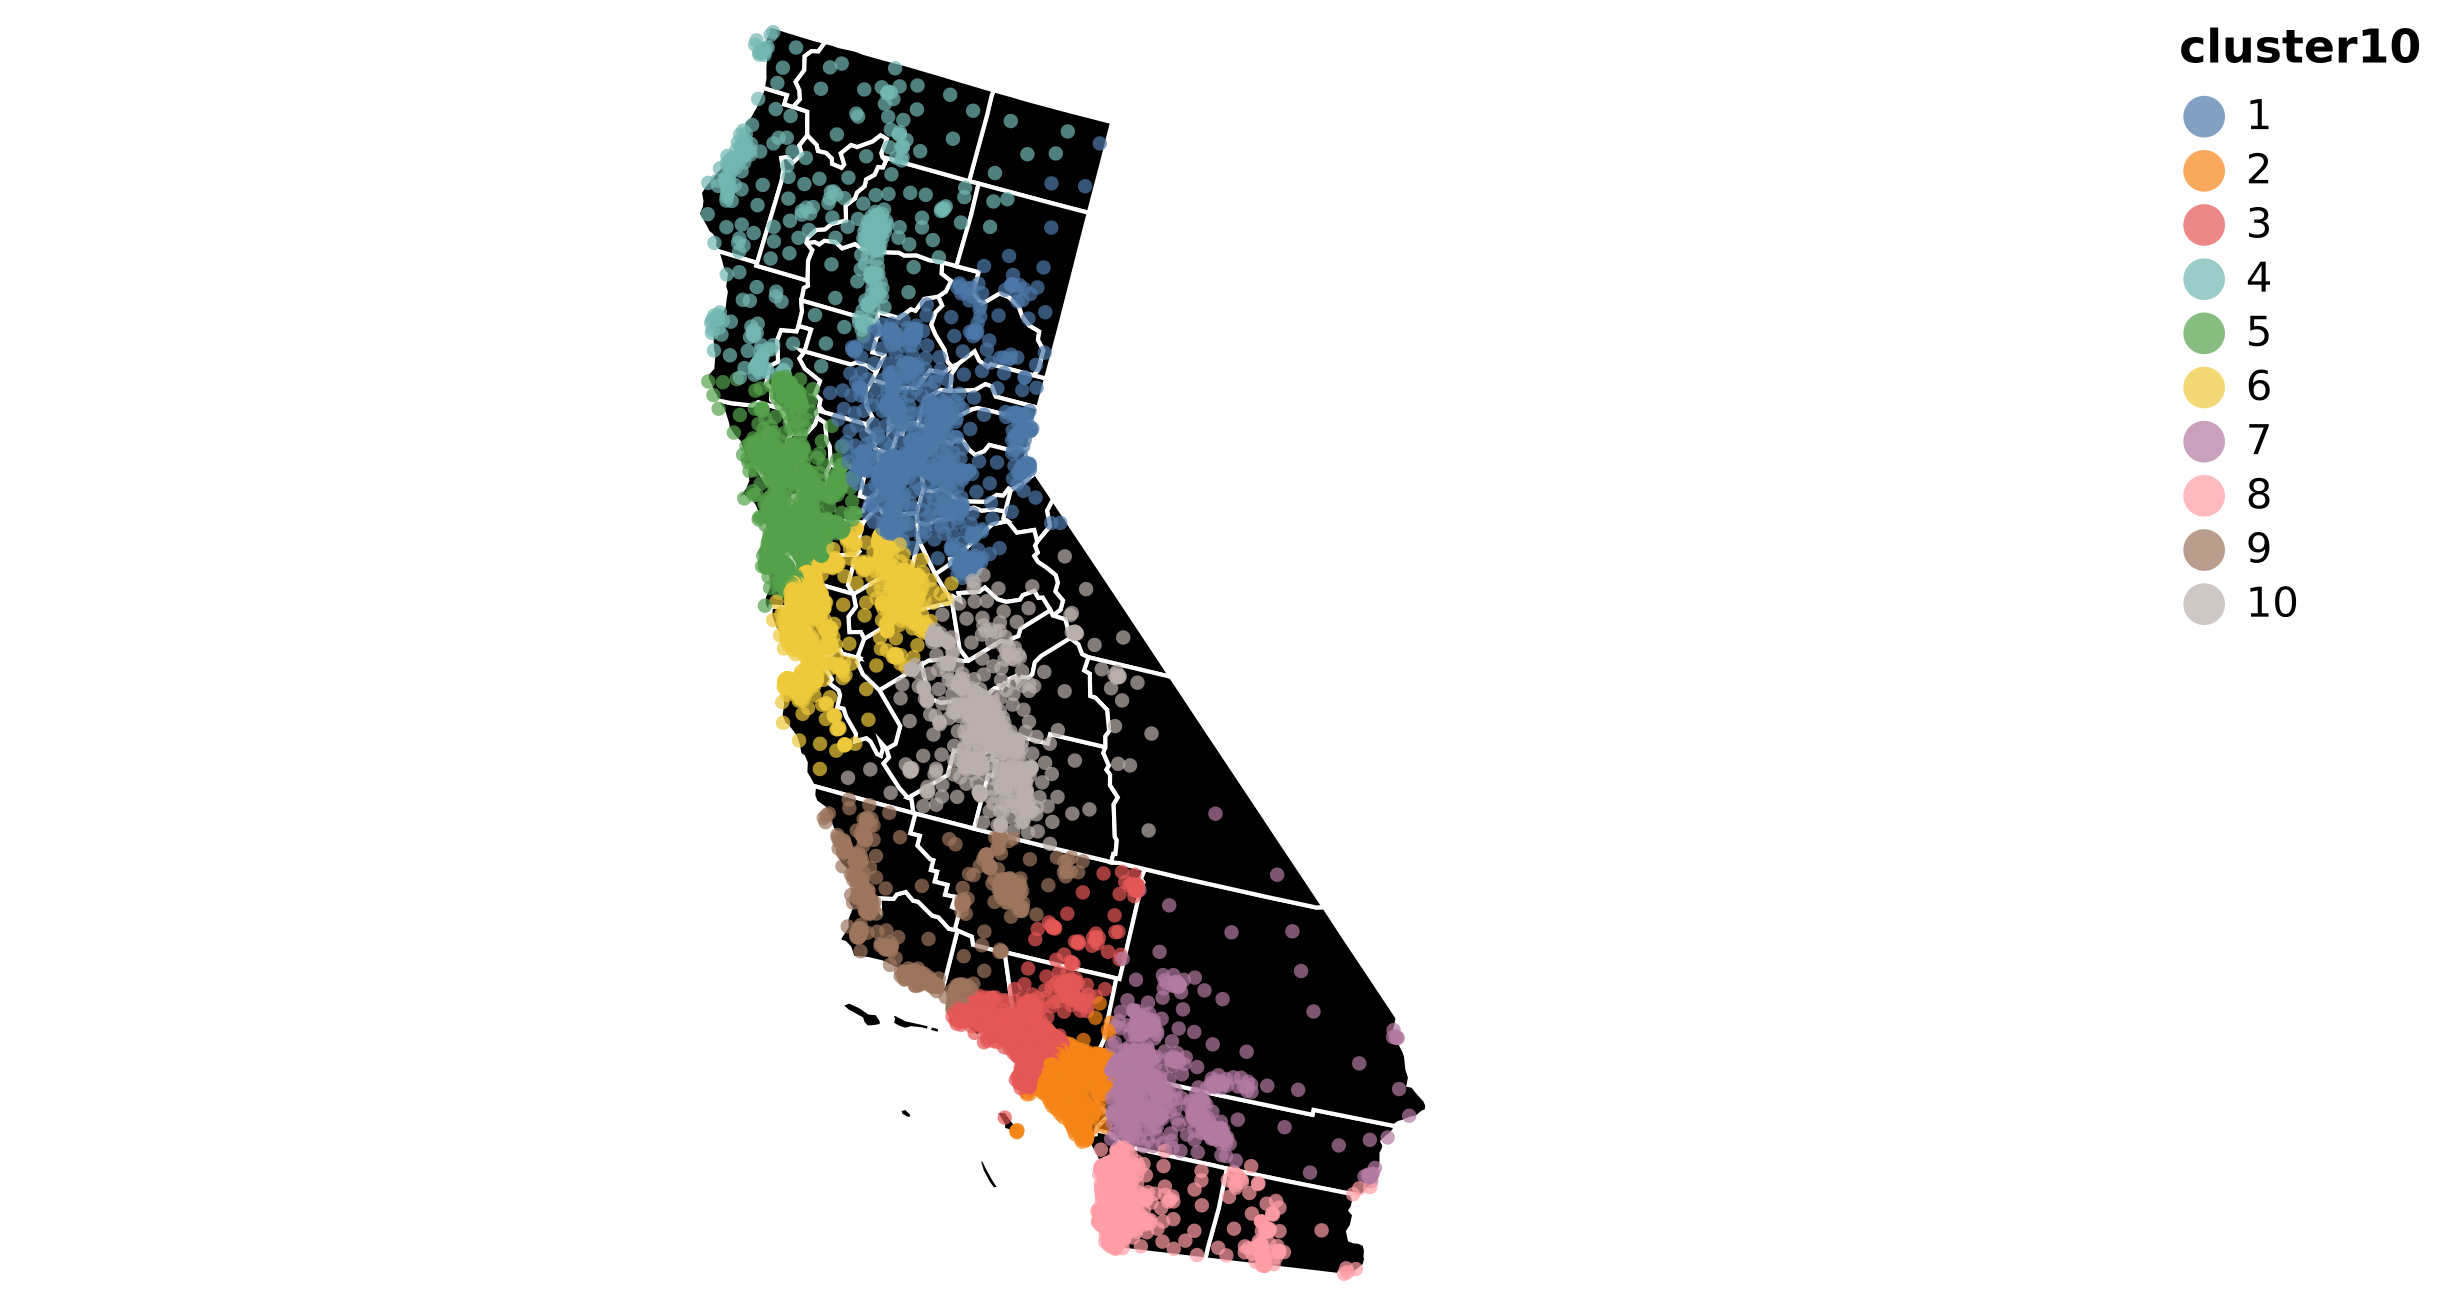

In [8]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="cluster10:n"                
)

p |> show_map

Yes, location affects price of the house but this means location as in proximity to water, to downtown, to a bus stop and so on

lets' see if this remains valid for the rest.

### 🟤K-medoids clustering
For this type of clustering, we need to build a distance matrix. We will use the `Distances` package for this purpose and compute the pairwise Euclidean distances.

In [9]:
xmatrix = Matrix(X)'
D = pairwise(Euclidean(), xmatrix, xmatrix,dims=2) 

K = kmedoids(D,10)
insertcols!(houses,3,:medoids_clusters=>K.assignments);

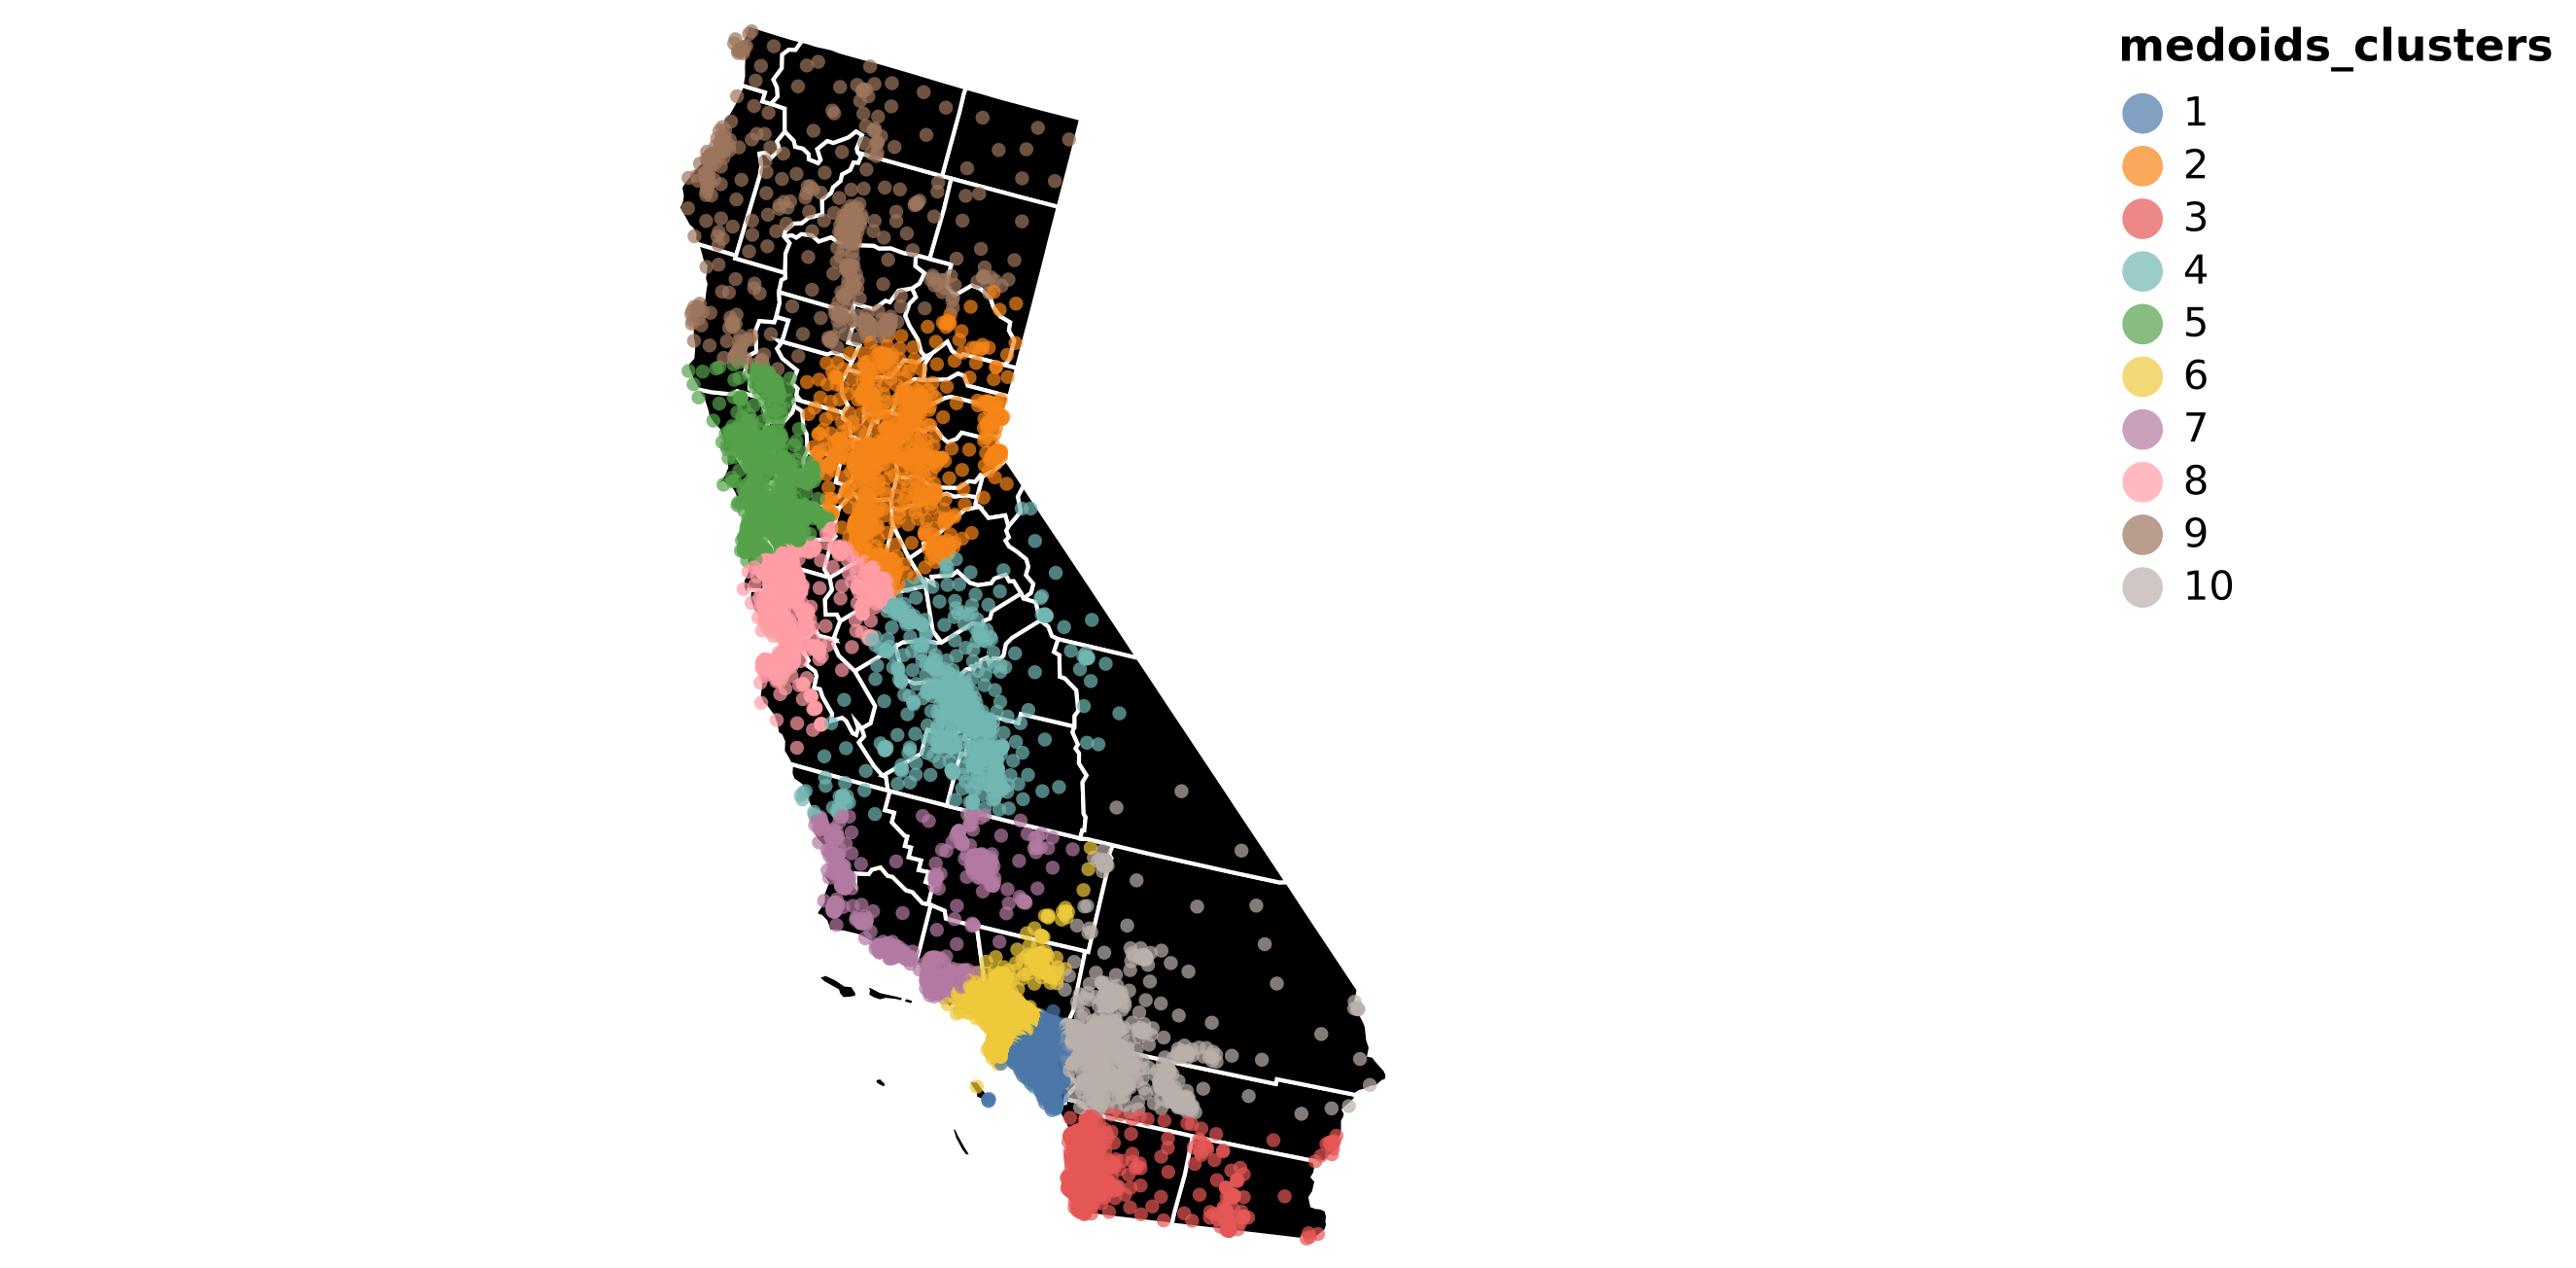

In [10]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="medoids_clusters:n"
                    
)


p |> show_map

### 🟤Hierarchial Clustering

In [11]:
K = hclust(D)
L = cutree(K;k=10)
insertcols!(houses,3,:hclust_clusters=>L);

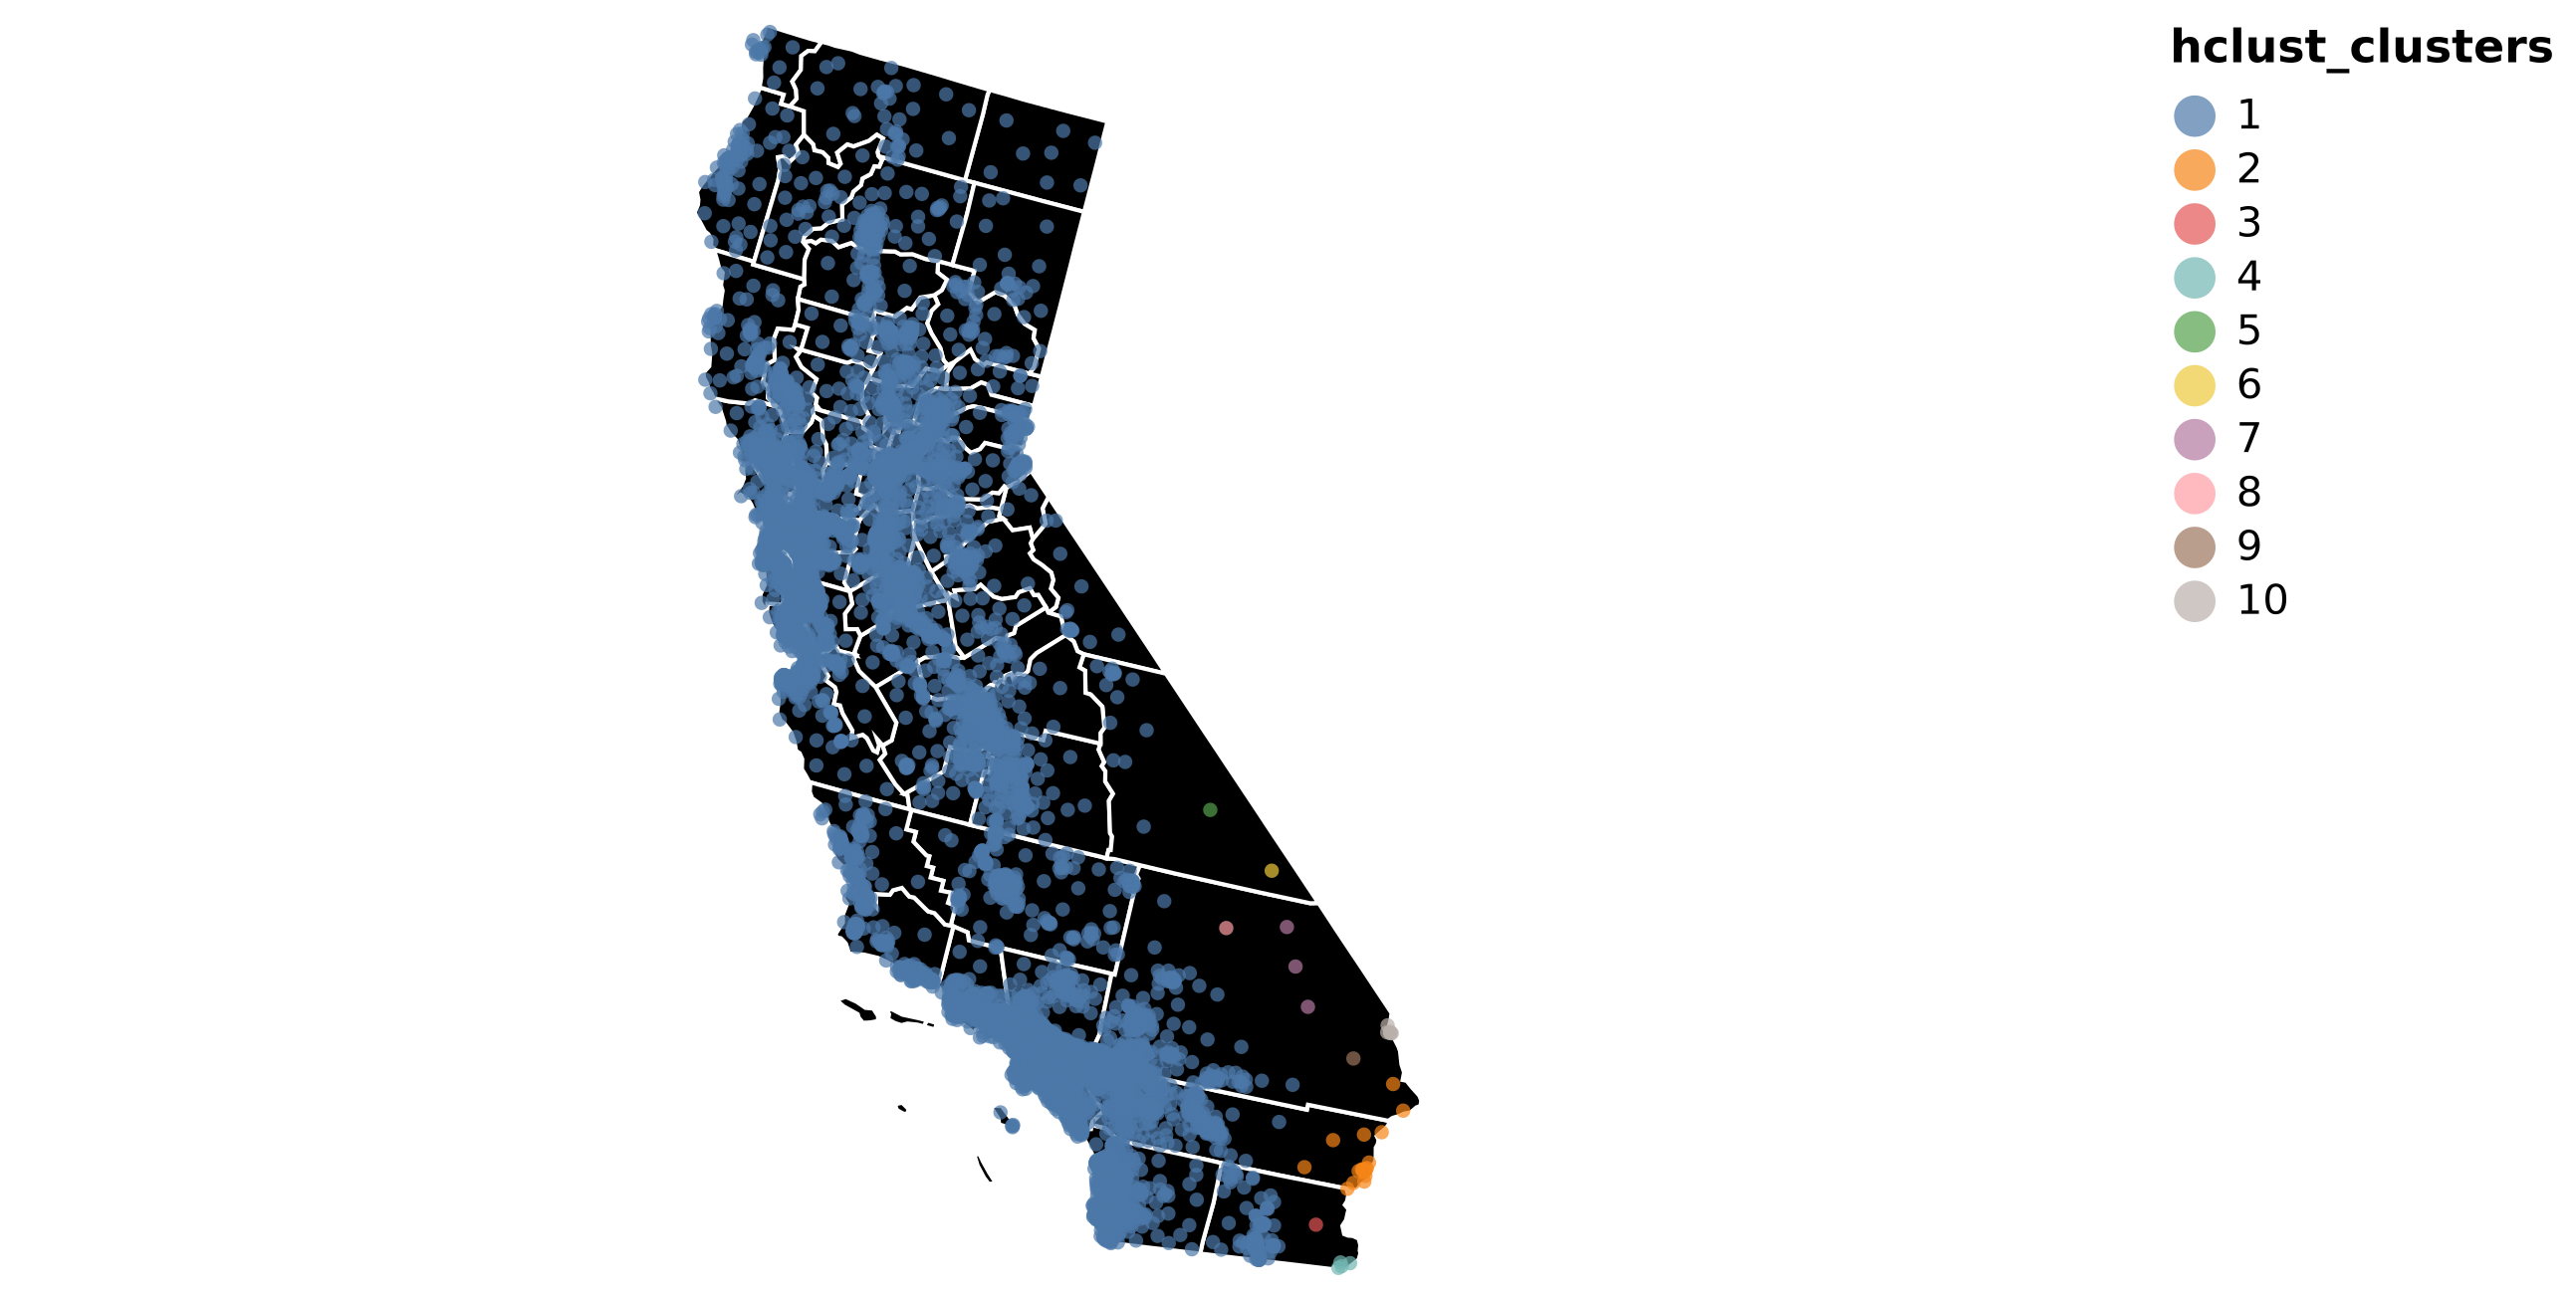

In [12]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="hclust_clusters:n"
                    
)

p |> show_map

### 🟤DBscan

In [13]:
using Distances
dclara = pairwise(SqEuclidean(), Matrix(X)',dims=2)
L = dbscan(dclara, 0.05, 10);

In [14]:
insertcols!(houses,3,:dbscanclusters3=>L.assignments);

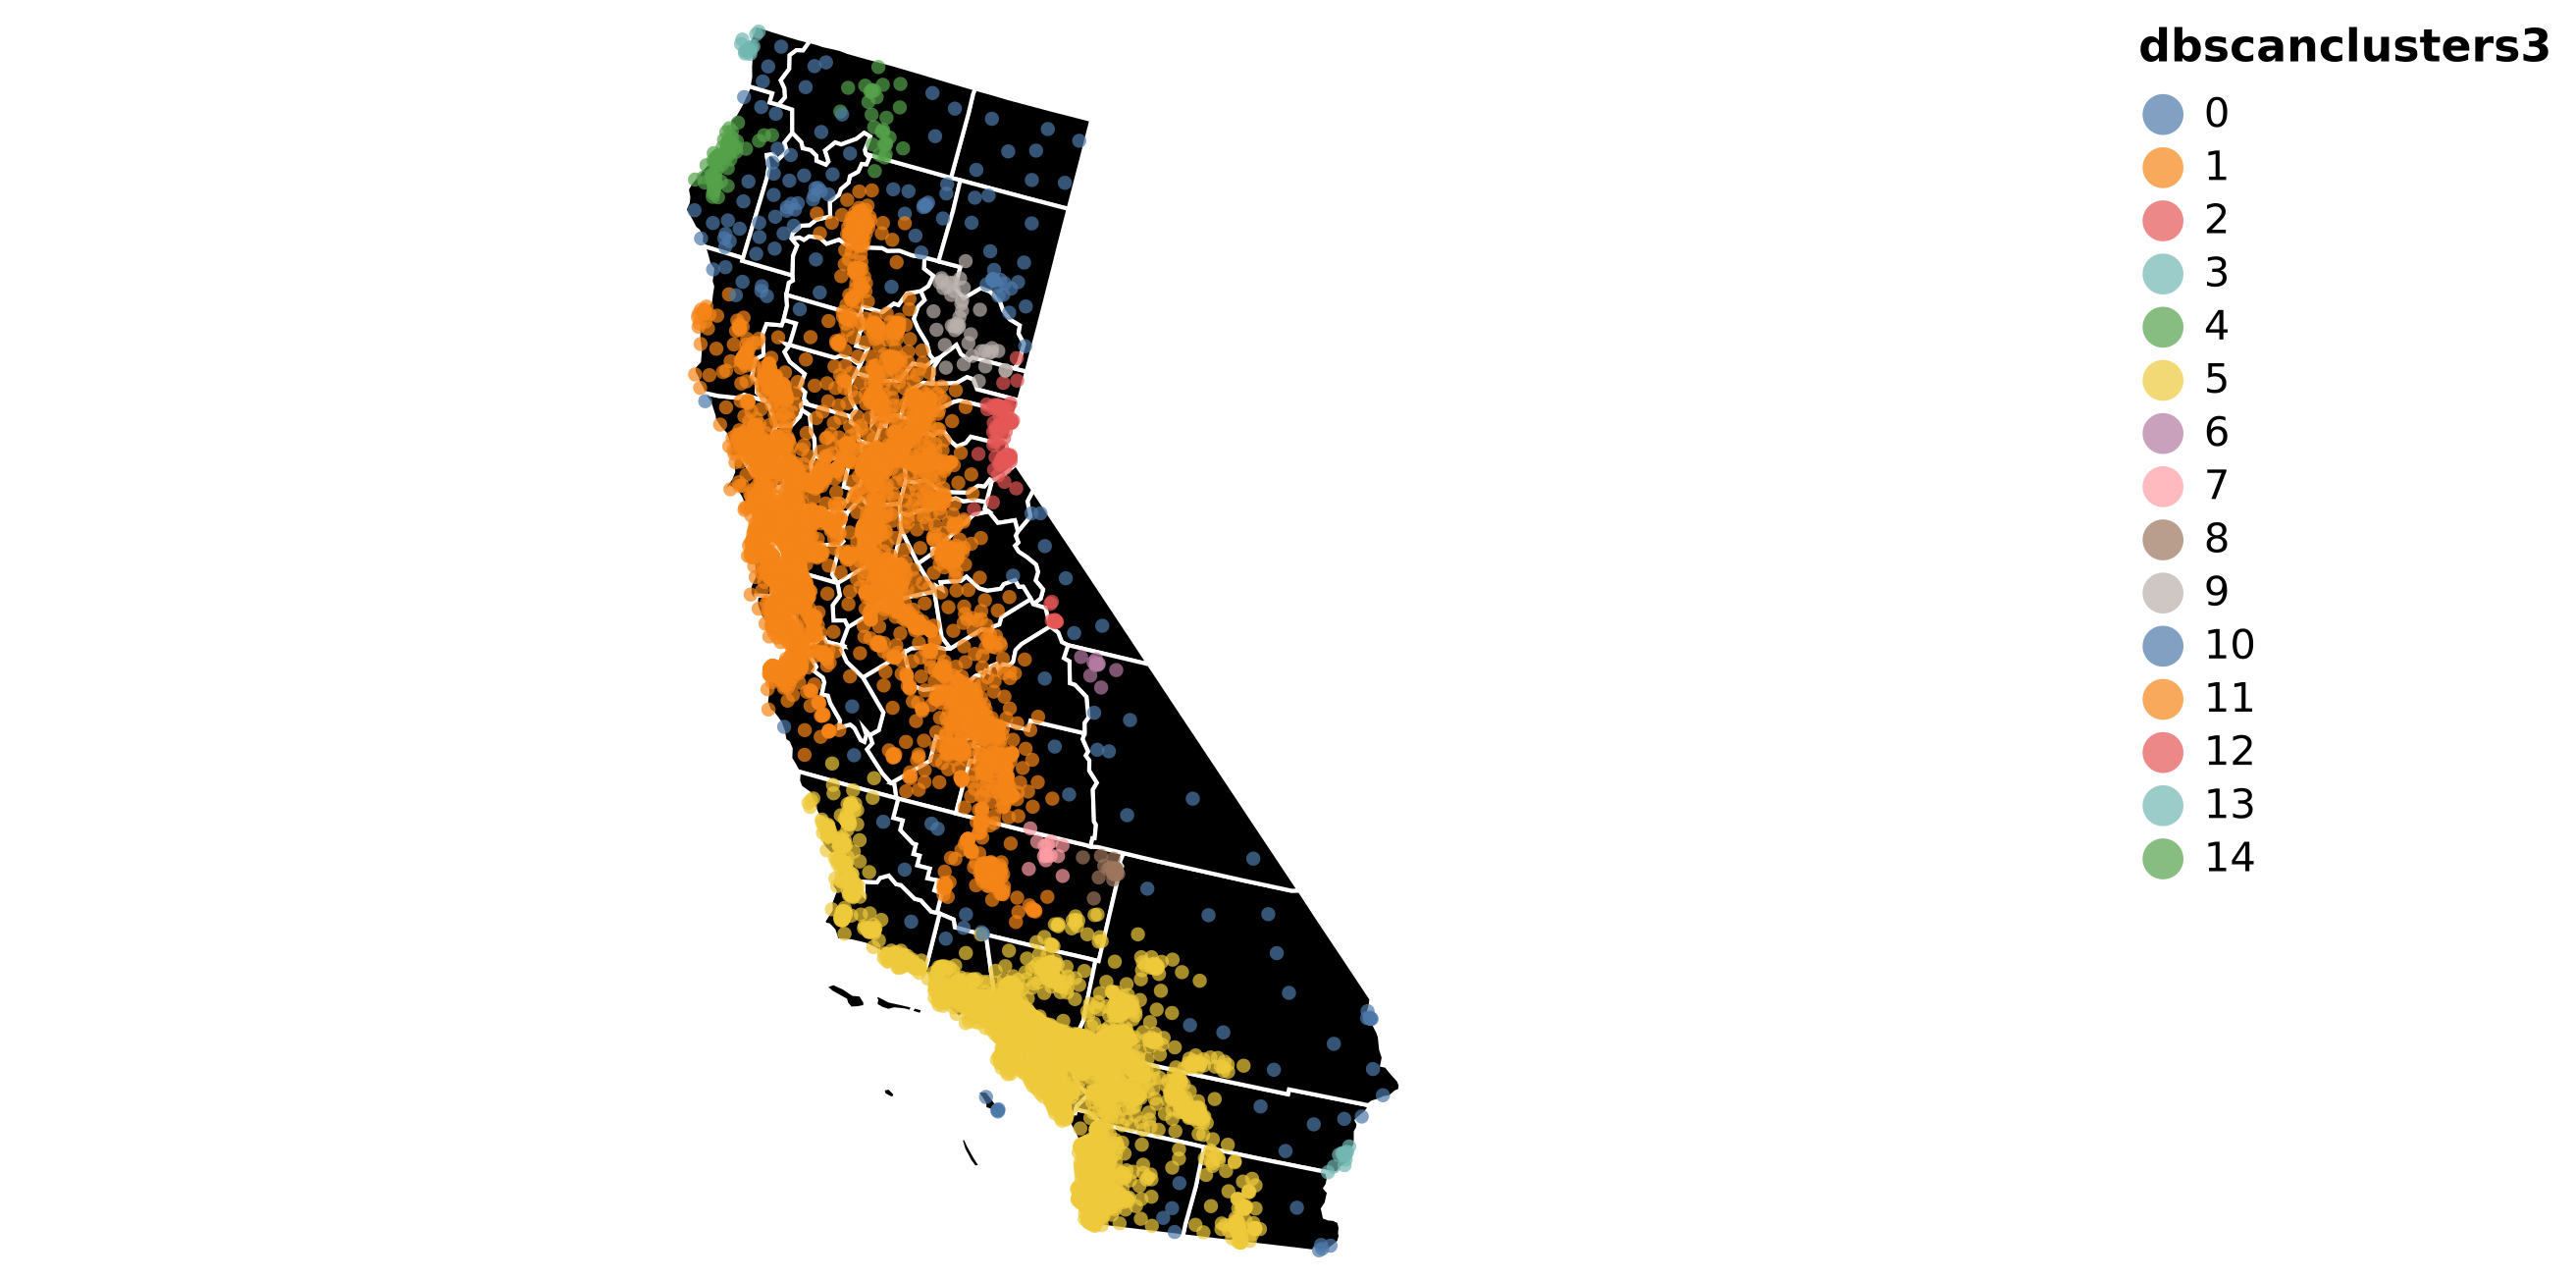

In [15]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
    
        fill=:black,
        stroke=:white
    },
    data={
        values=VV,
        format={
            type=:topojson,
            feature=:cb_2015_california_county_20m
        }
    },
    projection={type=:albersUsa},
)+
@vlplot(
    :circle,
    data=houses,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=12},
    color="dbscanclusters3:n"
                    
)

p |> show_map

# Finally...
After finishing this notebook, you should be able to:
- run clustering models on your data
- generate good looking plots of maps using the VegaLite package